In [1]:
import numpy as np
import mplhep as hep
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score
import uproot as up
import pandas as pd 

import awkward as ak
import os

os.environ["HOMELUDO"] = '/home/submit/mori25/'
os.environ["DPLUDO"] = '/work/submit/mori25/Darkphotons_ludo/'

from training_offline import Trainer, plot_ROC

Start loading data
Successfully imported data file to memory
Defined training and evaluation datasets
Train on 264313 events, of which a fraction 0.5709857801436552 is signal, and 19 variables
loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_standard_Y.json
loading successful


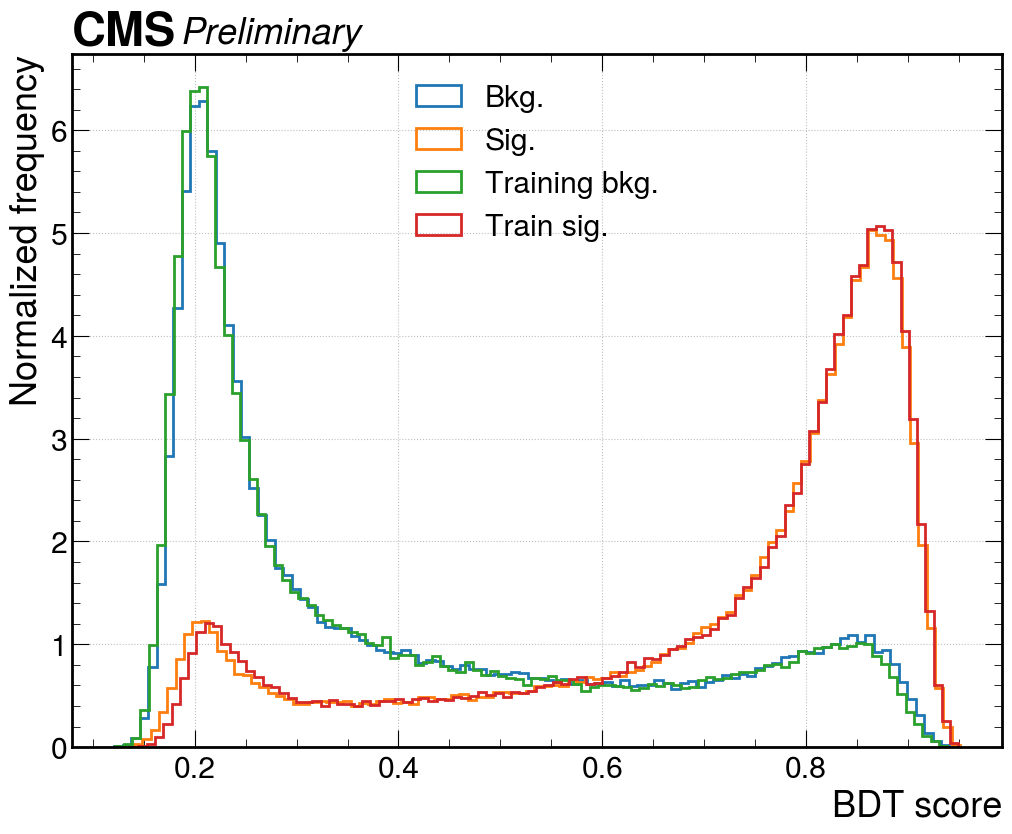

In [2]:
Y_forest = Trainer("Y", 'forest_standard')
Y_forest.complete_load()
Y_forest.plot_model()

Start loading data
Successfully imported data file to memory
Defined training and evaluation datasets
Train on 264313 events, of which a fraction 0.5709857801436552 is signal, and 19 variables
loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/tree_standard_Y.json
loading successful


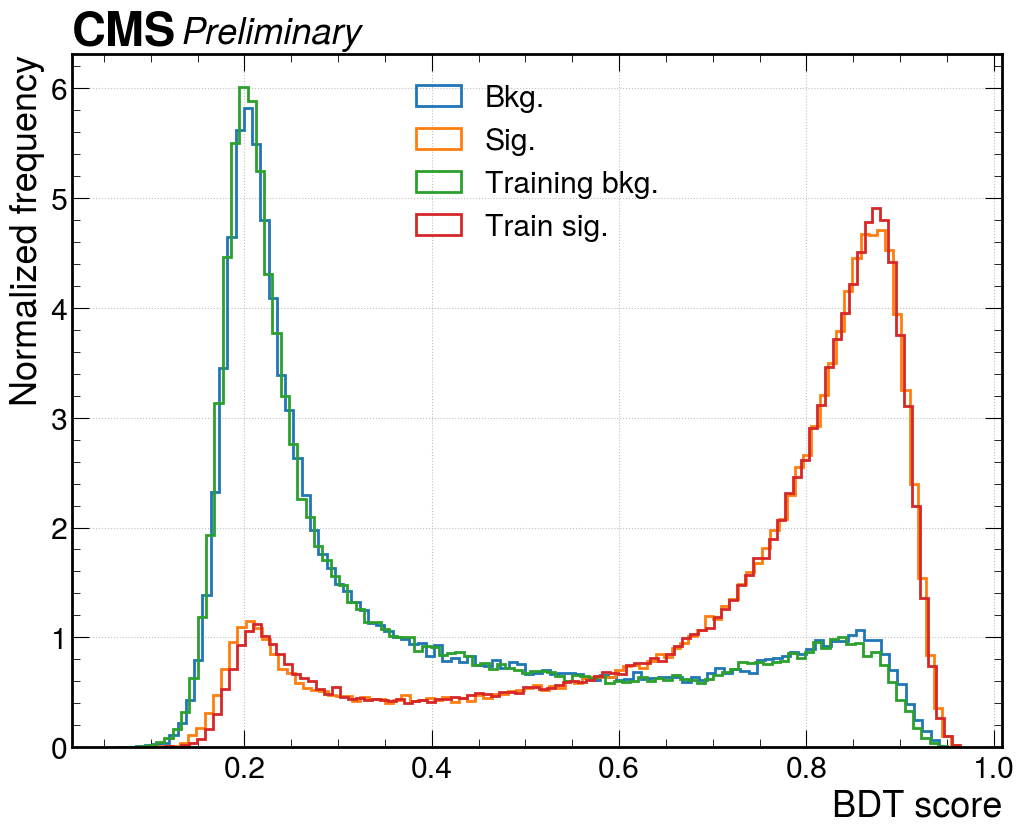

In [3]:
Y_tree = Trainer("Y", 'tree_standard')
Y_tree.complete_load()
Y_tree.plot_model()

Start loading data
Successfully imported data file to memory
Defined training and evaluation datasets
Train on 264313 events, of which a fraction 0.5709857801436552 is signal, and 21 variables
loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_ID_Y.json
loading successful


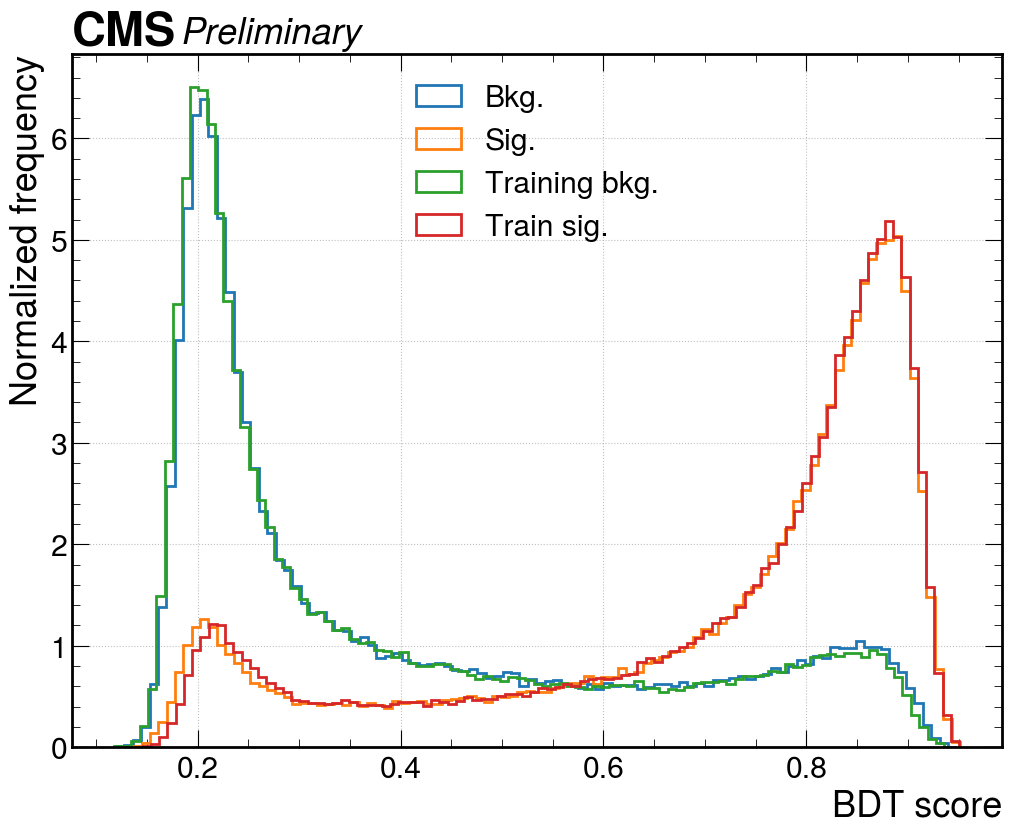

In [4]:
Y_forest_ID = Trainer("Y", 'forest_ID')
Y_forest_ID.complete_load()
Y_forest_ID.plot_model()

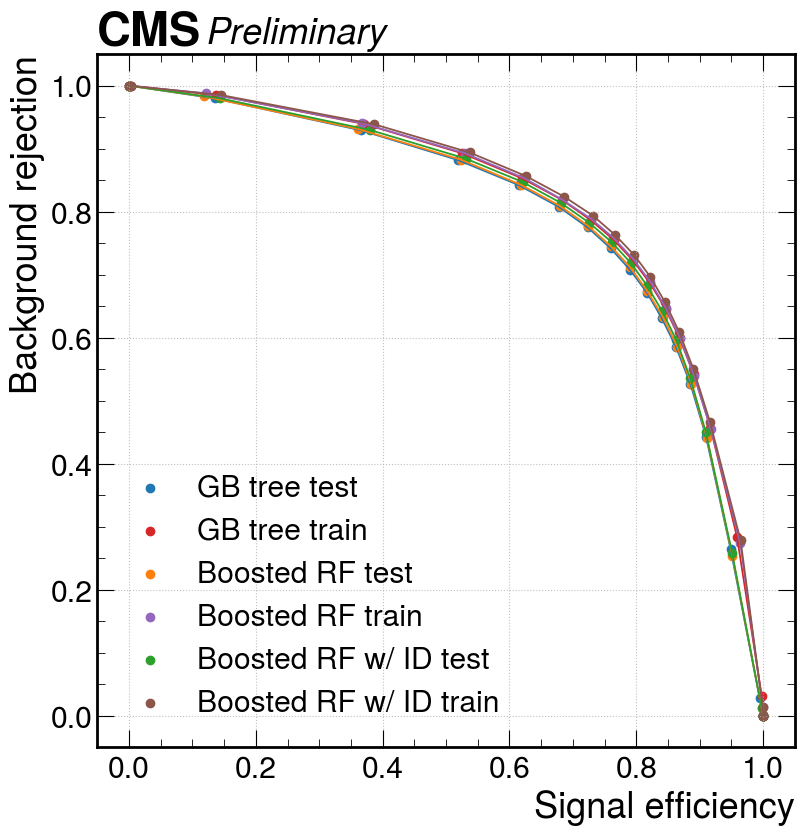

In [5]:
plot_ROC([Y_tree,Y_forest,Y_forest_ID], ["GB tree", "Boosted RF", "Boosted RF w/ ID"])

Start loading data
Successfully imported data file to memory
Defined training and evaluation datasets
Train on 172202 events, of which a fraction 0.49471986388079114 is signal, and 19 variables
loading model  /work/submit/mori25/Darkphotons_ludo/BDT/trained_models/forest_standard_Y.json
loading successful


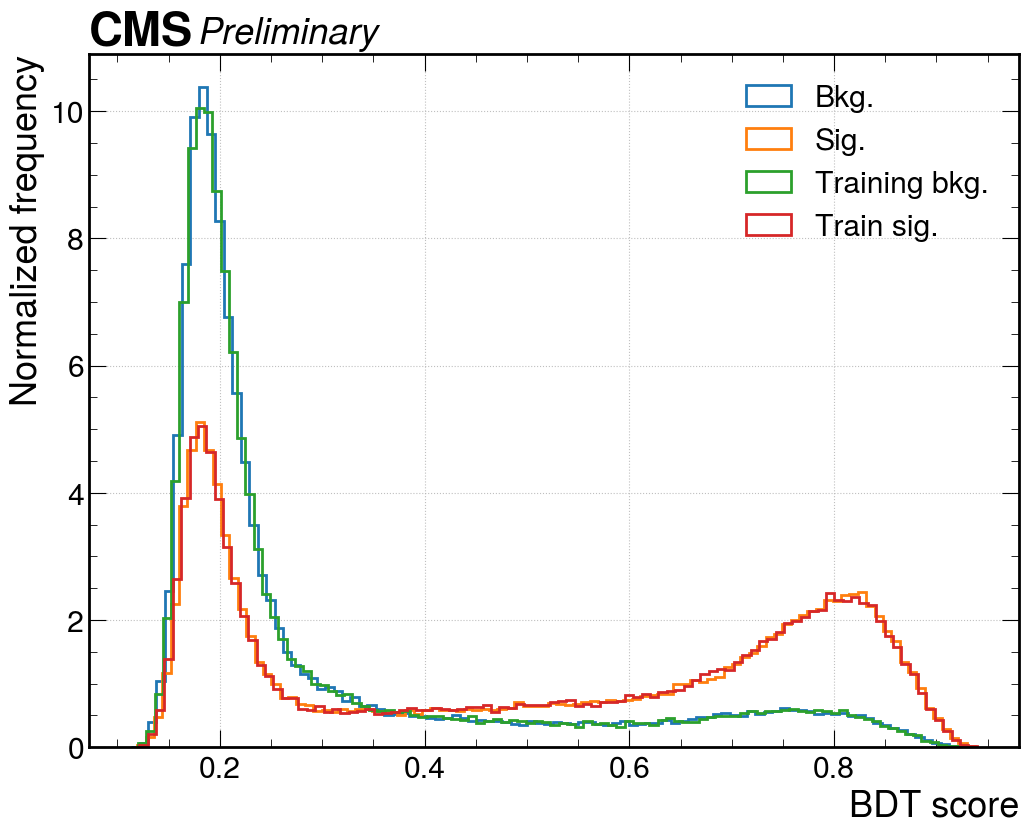

In [6]:
Y_forest_on_Jpsi = Trainer("Y", 'forest_standard')
Y_forest_on_Jpsi.complete_load("Jpsi")
Y_forest_on_Jpsi.plot_model()

Now look for optimal discriminators

In [7]:
predY = Y_forest.bst.predict(xgb.DMatrix(Y_forest.trainData_skinny))
predJpsi = Y_forest.bst.predict(xgb.DMatrix(Y_forest_on_Jpsi.trainData_skinny))

In [8]:
#Study cuts on discriminators to optimize for Y

id1Y=Y_tree.trainData["Muon_softMva1"]
id2Y=Y_tree.trainData["Muon_softMva2"]
sig_cut = Y_tree.trainData["Score"]==1
bkg_cut = Y_tree.trainData["Score"]==0

def efficiencyY(id_lim,dis_lim):
    sig = (predY[sig_cut] > dis_lim) & (id1Y[sig_cut] > id_lim) & (id2Y[sig_cut] > id_lim)
    s = np.sum(sig)
    bkg = (predY[bkg_cut] > dis_lim) & (id1Y[bkg_cut] > id_lim) & (id2Y[bkg_cut] > id_lim)
    b = np.sum(bkg)
    return s/np.sqrt(b) if b!= 0 else 0



In [9]:
id_vals = np.linspace(0.2,0.5,50)
vtx_vals= np.linspace(0.45,0.9,50)
XY, YY = np.meshgrid(id_vals,vtx_vals)
effY = np.vectorize(efficiencyY)(XY,YY)
idxY = np.unravel_index(np.argmax(effY),effY.shape)
print("Optimal discriminator cuts: \n SoftMVA (Muon ID): ", XY[idxY], "\n BDT (Vertex quantities): ", YY[idxY])

Optimal discriminator cuts: 
 SoftMVA (Muon ID):  0.43265306122448977 
 BDT (Vertex quantities):  0.7346938775510204


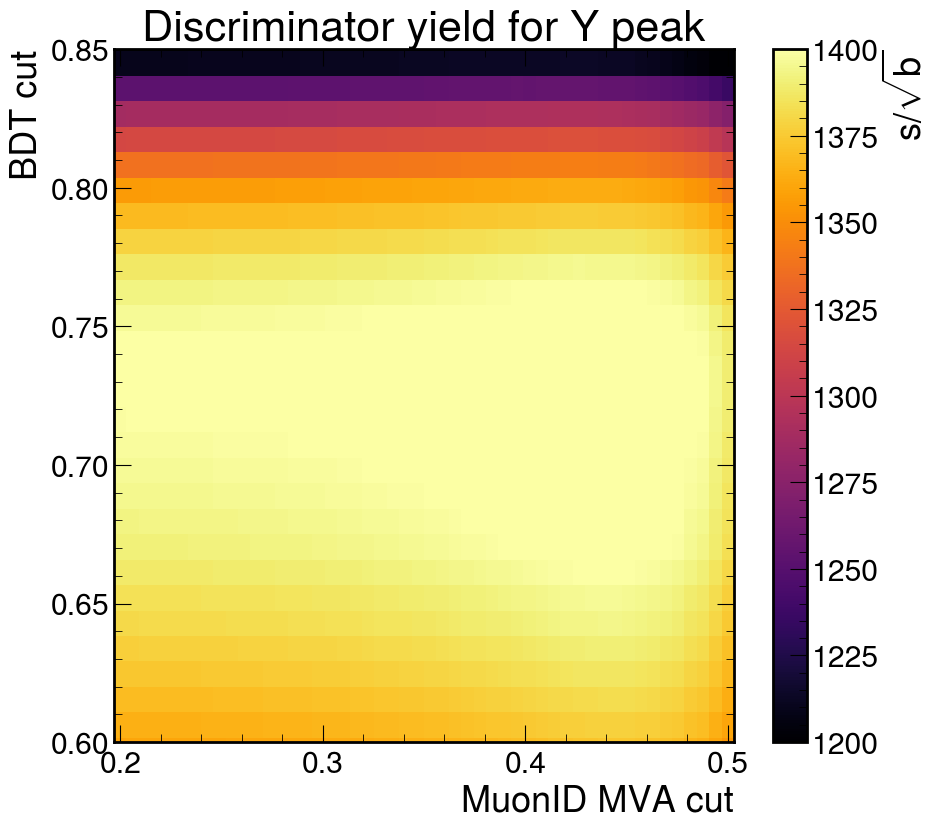

In [10]:
plt.figure(figsize=(10, 9))
pcm = plt.pcolormesh(XY, YY, effY, shading='auto', cmap='inferno',vmin=1200,vmax=1400)# norm=matplotlib.colors.LogNorm()
colorbar = plt.colorbar(pcm, label='$s/\sqrt{b}$')
# colorbar_ticks = [1000,1300 , 2000]  # Define your desired tick positions
# colorbar.set_ticks(colorbar_ticks)
plt.xlabel('MuonID MVA cut')
plt.ylabel('BDT cut')
plt.title('Discriminator yield for Y peak')
plt.ylim(0.6,0.85)
plt.show()

In [11]:
id1Jpsi=Y_forest_on_Jpsi.trainData["Muon_softMva1"]
id2Jpsi=Y_forest_on_Jpsi.trainData["Muon_softMva2"]
sig_cut = Y_forest_on_Jpsi.trainData["Score"]==1
bkg_cut = Y_forest_on_Jpsi.trainData["Score"]==0

def efficiencyJpsi(id_lim,dis_lim):
    sig = (predJpsi[sig_cut] > dis_lim) & (id1Jpsi[sig_cut] > id_lim) & (id2Jpsi[sig_cut] > id_lim)
    s = np.sum(sig)
    bkg = (predJpsi[bkg_cut] > dis_lim) & (id1Jpsi[bkg_cut] > id_lim) & (id2Jpsi[bkg_cut] > id_lim)
    b = np.sum(bkg)
    return s/np.sqrt(b) if b!= 0 else 0

In [12]:
id_vals = np.linspace(0.2,0.5,50)
vtx_vals= np.linspace(0.2,0.8,50)
XY, YY = np.meshgrid(id_vals,vtx_vals)
effJpsi = np.vectorize(efficiencyJpsi)(XY,YY)
idxJpsi = np.unravel_index(np.argmax(effJpsi),effJpsi.shape)
print("Optimal discriminator cuts on Jpsi: \n SoftMVA (Muon ID): ", XY[idxJpsi], "\n BDT (Vertex quantities): ", YY[idxJpsi])

Optimal discriminator cuts on Jpsi: 
 SoftMVA (Muon ID):  0.3653061224489796 
 BDT (Vertex quantities):  0.46938775510204084


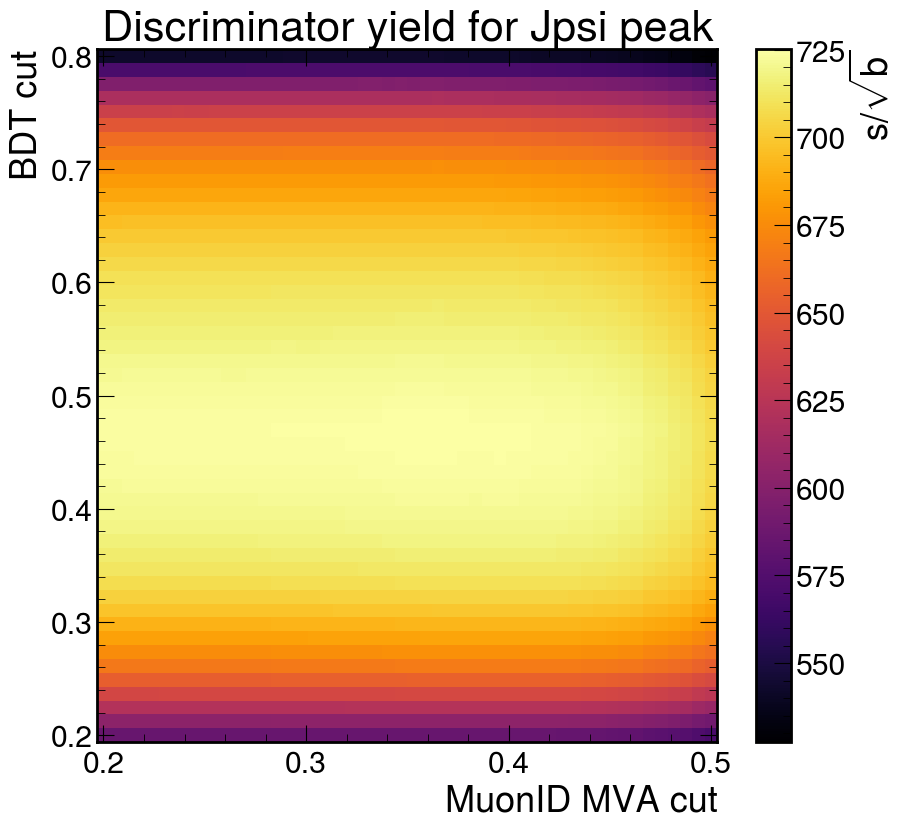

In [13]:
plt.figure(figsize=(10, 9))
pcm = plt.pcolormesh(XY, YY, effJpsi, shading='auto', cmap='inferno')# norm=matplotlib.colors.LogNorm()
colorbar = plt.colorbar(pcm, label='$s/\sqrt{b}$')
# colorbar_ticks = [1000,1300 , 2000]  # Define your desired tick positions
# colorbar.set_ticks(colorbar_ticks)
plt.xlabel('MuonID MVA cut')
plt.ylabel('BDT cut')
plt.title('Discriminator yield for Jpsi peak')
# plt.ylim(0.6,0.85)
plt.show()